In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "gdrive/'My Drive'/ML/"
project_dir =  "gdrive/'My Drive'/ML/GAN_DOGS/"

Mounted at /content/gdrive


In [0]:
#!mkdir gdrive/'My Drive'/ML/APTOS2019/
#!ls {project_dir}

In [0]:
#!cp {project_dir}/dogs_gan.ipynb gdrive/'My Drive'/ML/APTOS2019/

## Create Necessry directories in order to structure the project in your google drive
##our directory structure will be 


              gdrive/'My Drive'/ML/
                                  |
                                  DOGS_GAN
                                  |-- README.md
                                  |-- data
                                  |   |-- all-dogs.zip
                                  |   |-- Annotations.zip
                                  |   
                                  |-- dogs_gan.ipynb


In [0]:
if not os.path.isdir(root_dir):
  res = os.popen("mkdir {}".format(root_dir)).read()
  print (res)

if not os.path.isdir(project_dir):
  res = os.popen("mkdir {}".format(project_dir)).read()
  print (res)

data_dir  = "{}data/".format(project_dir)
if not os.path.isdir(data_dir):
  res = os.popen("mkdir {}".format(data_dir)).read()
  print (res)

In [0]:
!ls {data_dir}
#!unzip {data_dir}/all-dogs.zip -d {data_dir}
#!unzip {data_dir}/Annotation.zip -d {data_dir}
#!ls

all-dogs  all-dogs.zip	Annotation  Annotation.zip  __MACOSX  model_checkpoints


## Install kaggle commands on system to download the dataset


*   Make sure you have registered for the kaggle from the same comptetion
*   Download the  kaggle.json credential file into your ML folder which will be needed to authorize  your download requests for the datasets.
* copy the kaggle.json credential file ./kaggle directory  and change permissions



In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp {root_dir}/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### Download the data set from Kaggle to the data directory directly using command below

In [0]:
#!rm {data_dir}*
!kaggle competitions download -c generative-dog-images  -p {data_dir}

all-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)
Annotation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!ls {data_dir}

all-dogs  all-dogs.zip	Annotation  Annotation.zip  __MACOSX  model_checkpoints


## Kickstart the project

#### Now that we have our working directory setup we can start working with our project
#### Step 1 is to append the current root directory to python path so that we can import  necessary libraries and python functions from our script

#### Step 2 Below we are importing  kerasutil which is in our root directory

In [0]:
import sys
sys.path.append("gdrive/My Drive/ML/")
import download_utils

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2  # for image processing
import scipy.io
import os
import keras_utils
from keras_utils import reset_tf_session 
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.14.0
2.2.4


In [0]:
plt.rcParams.update({'axes.titlesize': 'small'})

In [0]:
IMG_SIZE = 64

In [0]:
dogs_imgages = data_dir.replace("'", '')+"all-dogs/"
annotations = data_dir.replace("'", '')+"Annotation/"

In [0]:
#!ls {data_dir}/all-dogs

In [0]:
import glob

In [0]:
images = [f for f in glob.glob(dogs_imgages + "*.jpg")]
annotations = [f for f in glob.glob(annotations + "*/n*")]

In [0]:
print (images[:5])
print (annotations[:2])

['gdrive/My Drive/ML/GAN_DOGS/data/all-dogs/n02113624_925.jpg', 'gdrive/My Drive/ML/GAN_DOGS/data/all-dogs/n02113624_333.jpg', 'gdrive/My Drive/ML/GAN_DOGS/data/all-dogs/n02113624_720.jpg', 'gdrive/My Drive/ML/GAN_DOGS/data/all-dogs/n02113624_8304.jpg', 'gdrive/My Drive/ML/GAN_DOGS/data/all-dogs/n02113624_6921.jpg']
['gdrive/My Drive/ML/GAN_DOGS/data/Annotation/n02085620-Chihuahua/n02085620_10621', 'gdrive/My Drive/ML/GAN_DOGS/data/Annotation/n02085620-Chihuahua/n02085620_10074']


In [0]:
from PIL import Image
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import random


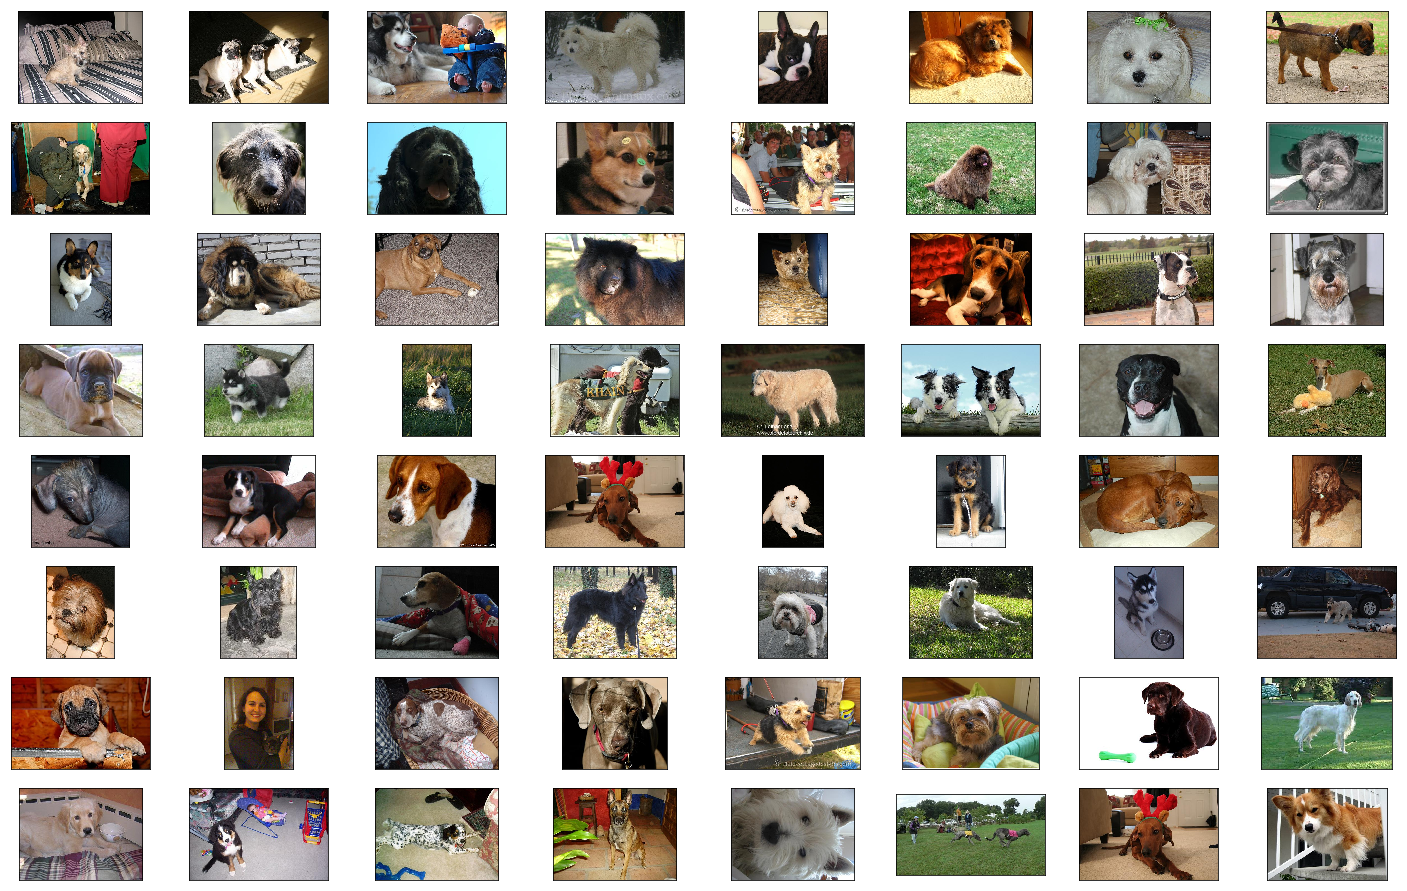

In [0]:
images_to_display = random.choices(images, k=64)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(images_to_display):
    ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = Image.open(img_byte)
    plt.imshow(img)

(333, 500, 3)


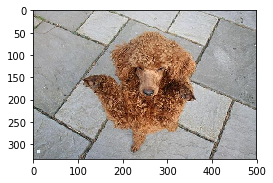

In [0]:
img = cv2.imread(images[100])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
#cv2_imshow(img)
fig = plt.figure(figsize=(4,8))
plt.imshow(img)
plt.show()

In [0]:
def get_bbox(dog_id):
  breed_folder = [x.rsplit('/', 1)[0] for x in annotations if dog_id in x.split('/')[-1] ]
  #print (breed_folder)
  if len(breed_folder) != 1:
    return None
  breed_folder = breed_folder[0]
  file_name = "{}/{}".format(breed_folder, dog_id)
  #print (file_name)
  root = ET.parse(file_name).getroot()
  objects = root.findall('object')
  for obj in objects:
      bndbox = obj.find('bndbox')
      xmin = int(bndbox.find('xmin').text)
      ymin = int(bndbox.find('ymin').text)
      xmax = int(bndbox.find('xmax').text)
      ymax = int(bndbox.find('ymax').text)
  bbox = (xmin, ymin, xmax, ymax)
  #print("Bounding Box: ", bbox)
  return bbox
  
  

In [0]:
dog_id = 'n02109961_16718'

In [0]:
box = get_bbox(dog_id)

In [0]:
def get_annotated_img(img_file):
  dog_id = img_file.split('/')[-1].split('.')[0]
  #raw_bytes = read_raw_from_zip(zip_dogs,"all-dogs/{}.jpg".format(dog_id))
  #img = decode_image_from_raw_bytes(raw_bytes)
  img = cv2.imread(img_file)
  bbox = get_bbox(dog_id)
  if bbox:
    xmin, ymin, xmax, ymax = bbox
    img = img[ymin:ymax,xmin:xmax]
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
  

In [0]:
img = get_annotated_img(images[4])
img.shape

(64, 64, 3)

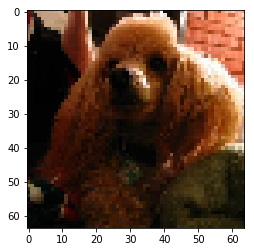

In [0]:
fig = plt.figure()
plt.imshow(img)
plt.show()

In [0]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

W0724 10:06:34.804360 140110294300544 deprecation_wrapper.py:119] From gdrive/My Drive/ML/keras_utils.py:68: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 10:06:34.806764 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0724 10:06:34.809017 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 10:06:34.863228 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 10:06:34.864639 14011029

In [0]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from copy import deepcopy
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [0]:
def generate_training_images(images, batch_size=100):
  cur_batch = []
  for image in images:
    img = get_annotated_img(image)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE) ) 
    cur_batch.append(img)
    if len(cur_batch) == batch_size:
      yield cur_batch
      cur_batch = []
    cur_batch.append(random_rotation(deepcopy(img) ))
    if len(cur_batch) == batch_size:
      yield cur_batch
      cur_batch = []
    cur_batch.append(random_noise(deepcopy(img) ))
    if len(cur_batch) == batch_size:
      yield cur_batch
      cur_batch = []
    cur_batch.append(horizontal_flip(deepcopy(img) ))
    if len(cur_batch) == batch_size:
      yield cur_batch
      cur_batch = []
  return cur_batch

In [0]:
IMG_SHAPE = (64, 64, 3)

In [0]:
CODE_SIZE =256
dim = 8
depth = 64*4
dropout = 0.4

generator = Sequential()

#layer 1  : Dense Layer with BatchNormalization and relu activation
generator.add(L.Dense(dim * dim * depth, 
                      input_shape=(CODE_SIZE,)))
generator.add(L.LeakyReLU(alpha=0.2))
generator.add(L.BatchNormalization(momentum=0.8))


#layer2 :  Reshape and Dropout
generator.add(L.Reshape((dim, dim, depth)))
#generator.add(L.Dropout(dropout))


#layer 3 : Transpose conv layer
generator.add(L.Deconv2D(int(depth/2), 
                         kernel_size=(5,5)))
generator.add(L.BatchNormalization(momentum=0.8))
generator.add(L.LeakyReLU(alpha=0.2))




#layer 4 : upsample conv layer
generator.add(L.UpSampling2D())
generator.add(L.Deconv2D(int(depth/4), 
                         kernel_size=(5,5)))
generator.add(L.Dropout(dropout))
generator.add(L.BatchNormalization(momentum=0.8))
generator.add(L.LeakyReLU(alpha=0.2))


generator.add(L.Deconv2D(int(depth/4), 
                         kernel_size=(5,5)))
generator.add(L.Dropout(dropout))
generator.add(L.BatchNormalization(momentum=0.8))
generator.add(L.LeakyReLU(alpha=0.2))


#layer 5 : upsample conv layer
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(int(depth/4), 
                         kernel_size=(5,5)))
generator.add(L.Dropout(dropout))
generator.add(L.BatchNormalization(momentum=0.8))
generator.add(L.LeakyReLU(alpha=0.2))

#layer 5 : Image generation Layer
generator.add(L.Conv2D(3,kernel_size=5,activation=None))

W0724 10:06:38.867662 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0724 10:06:38.954193 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0724 10:06:39.001839 140110294300544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#generator = load_model('./G')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             4210688   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
__________

In [0]:
discriminator = Sequential()
depth = 64
dropout = 0.4

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(depth, (3, 3),padding='same') )
discriminator.add(L.LeakyReLU(0.1))

discriminator.add(L.Conv2D(depth*2, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Dropout(dropout))

discriminator.add(L.MaxPool2D())

discriminator.add(L.Conv2D(depth*3, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))

discriminator.add(L.MaxPool2D())

discriminator.add(L.Conv2D(depth, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Dropout(dropout))

discriminator.add(L.MaxPool2D())
discriminator.add(L.Flatten())
discriminator.add(L.Dense(512,activation='tanh'))
discriminator.add(L.Dense(CODE_SIZE,activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

W0724 10:06:39.580053 140110294300544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
#discriminator = load_model('./D')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 192)       221376    
__________

In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)

In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss, var_list=discriminator.trainable_weights)

W0724 10:06:40.694475 140110294300544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
########################
###generator training###
########################

g_loss = -tf.log(1-logp_gen)

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(len(images)), size = int(bsize/2) )
    cur_batch = []
    for idx in idxs:
        img = get_annotated_img(images[idx]) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE) )
        #print (img.shape)
        cur_batch.append( img)
        
    idxs = np.random.choice(np.arange(len(images)), size= bsize-int(bsize/2) )
    for idx in idxs:
        img = get_annotated_img(images[idx]) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE) )
        if idxs[0]%3 == 0:
          cur_batch.append( random_rotation(img))
        elif idxs[0]%3 == 1:
          cur_batch.append( random_noise(img))
        else:
          cur_batch.append( horizontal_flip(img))
        #print (img.shape)
    return np.array(cur_batch)

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
            
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [0]:
import tqdm_utils

In [0]:
#!ls {data_dir}

0


W0724 10:08:23.879207 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 10:08:23.901178 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 10:08:23.919856 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 10:08:23.938705 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 10:08:23.957153 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 10:08:23.978172 140110294300544 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


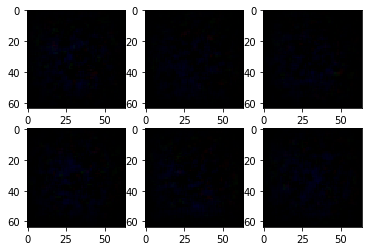

FileNotFoundError: ignored

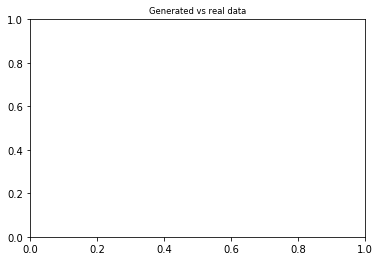

In [0]:
from IPython import display

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer, feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    display.clear_output(wait=True)
    print (epoch)
    if epoch %100==0:
        display.clear_output(wait=True)
        print (epoch)
        sample_images(2,3,True)
        sample_probas(1000)
        if epoch%500 ==0 and epoch > 0:
          generator.save('{}/mode_checkpoints/G_{}'.format(data_dir.replace("'",''), epoch))
          discriminator.save('{}/mode_checkpoints/D_{}'.format(data_dir.replace("'",''), epoch))
        